 # Tutorial 08 - (Recap) Neural Networks
 
 ## Dr. David C. Schedl

 Note: this tutorial is geared towards students **experienced in programming** and aims to introduce you to **Neural Networks**.



## Setup
As first step, we need to import the necessary libraries. 

In [1]:
# Setup and import of libraries
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs, make_circles


# Let's set the random seed to make this reproducible (the same for everybody).
np.random.seed(1337)
random.seed(1337)

# Let's train an MLP to classify points (like Tensorflow Playground)

We will at first generate some data using scikit-learn.

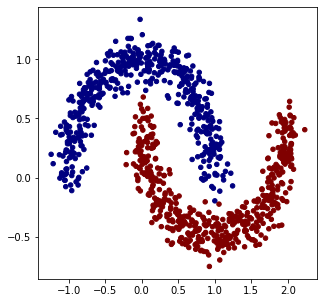

[-1  1]


In [2]:
# make up a dataset
X, y = make_moons(n_samples=1000, noise=0.1)

y = y * 2 - 1  # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")
plt.show()
print(np.unique(y))

Let's set up an MLP in PyTorch. <br>

Our model takes 2 inputs and outputs 1 value. <br>
We will use 2 hidden layers with 16 neurons each. <br>
Thus, our MLP has 337 parameters. <br>


In [3]:
# MLP in PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F


class TorchMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.tanh(self.fc2(h1))
        o = self.fc3(h2)
        return o


torch_model = TorchMLP()

print(torch_model)
# print number of parameters
print(sum(p.numel() for p in torch_model.parameters()))

TorchMLP(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)
337


In [4]:
# initial accuracy (RANDOM)
preds = torch_model(torch.Tensor(X)).data.numpy()
accuracy = [(yi > 0) == (scorei > 0) for yi, scorei in zip(y, preds)]
acc = sum(accuracy) / len(accuracy)
print(acc)

[0.5]


In [13]:
# soft marigin loss
torch_loss_fun = F.soft_margin_loss
optimizer = torch.optim.SGD(
    torch_model.parameters(),
    lr=5,  # learning rate
    weight_decay=1e-4,  # L2 regularization
)
batch_size = 32  # mini-batch size

# optimization
for k in range(100):

    # use mini-batch
    if batch_size is None:
        Xb, yb = X, y # entire dataset
    else:
        # use a random batch of the data
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    # reset gradients
    optimizer.zero_grad()

    # forward
    torch_scores = torch_model(torch.from_numpy(Xb).float())
    torch_loss = torch_loss_fun(
        torch_scores, torch.from_numpy(yb).reshape(-1, 1).float()
    )
    # L2 regularization is in the optimizer, now!!

    # backward
    torch_loss.backward()

    # update (sgd)
    optimizer.step()

    # also get accuracy
    accuracy = [
        (yi > 0) == (scorei.data.item() > 0) for yi, scorei in zip(yb, torch_scores)
    ]
    acc = sum(accuracy) / len(accuracy)

    if k % 10 == 0:
        print(f"step {k} loss {torch_loss.data}, accuracy {acc*100}%")

step 0 loss 0.19032599031925201, accuracy 96.875%
step 10 loss 0.09362265467643738, accuracy 96.875%
step 20 loss 0.734365701675415, accuracy 84.375%
step 30 loss 0.006106949411332607, accuracy 100.0%
step 40 loss 0.003369690151885152, accuracy 100.0%
step 50 loss 0.008970621973276138, accuracy 100.0%
step 60 loss 0.004092395305633545, accuracy 100.0%
step 70 loss 0.006672484800219536, accuracy 100.0%
step 80 loss 0.07506505399942398, accuracy 96.875%
step 90 loss 0.008282103575766087, accuracy 100.0%


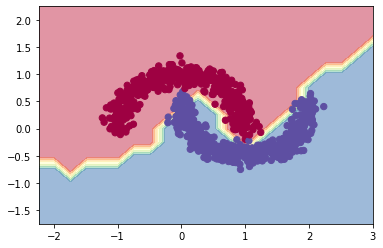

In [14]:
# visualize decision boundary (similar to tensorflow playground)

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
scores = torch_model(torch.from_numpy(Xmesh).float()).data.numpy()
Z = np.array([s > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

### Exercise 01 📝: Play with the data and the network
 
Change the MLP (number of layers and number of neurons per layer) and see how it affects the decision boundary. 
Switch to the `make_circles` dataset (instead of the `make_moons` function) and see how your network performs. <br>

Try to answer the following questions:
- How many parameters do the networks have and how does that affect performance (accuracy and timing)?
- What is the simplest and most complex network you can train to classify the data? Can it get too complex?
- What happens if you change the batch size? 

# CIFAR10 with PyTorch

Let's try to classify the CIFAR10 dataset. We can use the torchvision package to load the CIFAR10 dataset. 
After loading the dataset, we'll need to preprocess the images by reshaping them to a 1D tensor and normalizing the pixel values. The `transform` takes care of this.

Afterwards let's display some images from the dataset.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


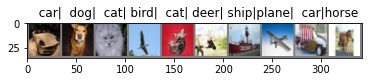

In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

batch_size = 100

# Load and preprocess the CIFAR10 dataset
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# the labels will be put in a separate vector as the original is just numbers, but we want text labels 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# display some images
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show 10 images
plt.title('|'.join('% 5s' % classes[labels[j].item()] for j in range(10)))
imshow(torchvision.utils.make_grid(images[:10], nrow=10))




Then let's define our model. We use PyTorch's nn module to define the architecture of the model. The input layer should have 3072 neurons ($32\times32\times3$), and the output layer should have 10 neurons, one for each class. 

Later you will change this model to an MLP. The number of neurons in the hidden layers, as well as the number of hidden layers, is up to you!


In [8]:
# Define the (linear) model
class CIFAR10(nn.Module):
    def __init__(self):
        super(CIFAR10, self).__init__()
        self.linear = nn.Linear(3072, 10)

    def forward(self, x):
        x = x.view(-1, 3072)
        return self.linear(x)




For training we define the loss function and optimizer. Let's use the cross-entropy loss function and a stochastic gradient descent (SGD) or Adam optimizer to train the model.

Then we need to loop over the training dataset, feed the images and labels to the model, compute the loss, perform backpropagation to update the model's parameters, and repeat for a certain number of epochs.

Afterwards we can test the model on the test dataset. We can use the `torch.no_grad()` context manager to temporarily set all the requires_grad flag to false. This will reduce memory usage and speed up computations. We don't need to compute gradients in the testing phase.

In [16]:
model = CIFAR10()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # keep loss for statistics
        running_loss += loss.item()
    # print statistics
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(trainloader)))

print('Finished Training')

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


Epoch 1 loss: 1.648
Epoch 2 loss: 1.460
Epoch 3 loss: 1.382
Epoch 4 loss: 1.325
Epoch 5 loss: 1.276
Epoch 6 loss: 1.235
Epoch 7 loss: 1.197
Epoch 8 loss: 1.163
Epoch 9 loss: 1.132
Epoch 10 loss: 1.108
Finished Training
Accuracy of the network on the 10000 test images: 51 %


Let's look at a few images from the test set and print the model's predictions.

Accuracy: 50.00% for 50 test images


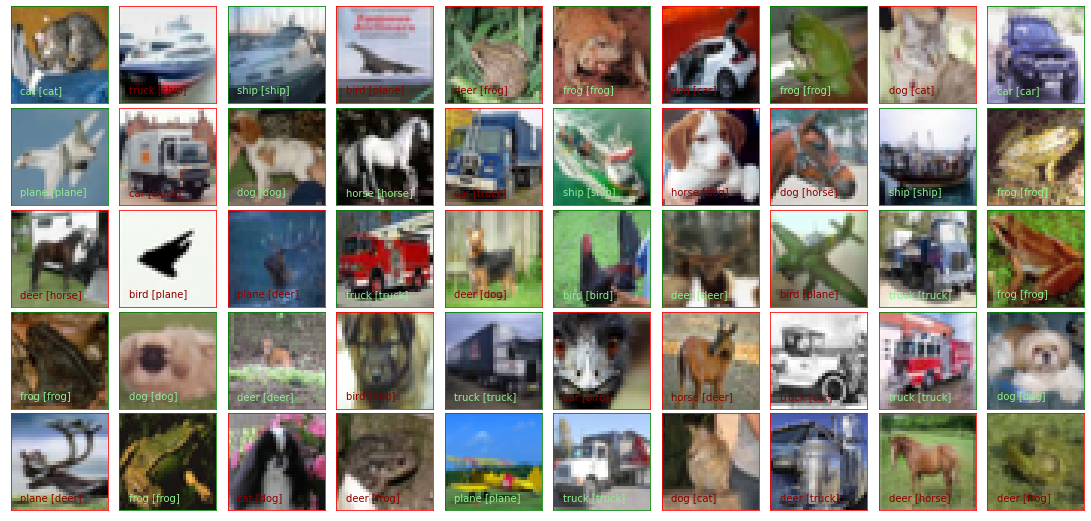

In [18]:
# get some random test images
images, labels = next(iter(testloader))


# set up a figure
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

_, prediction_label = torch.max(model(images).data, 1)

total, correct = 0, 0
# plot the images: each image is 28x28 pixels
for i,img in enumerate(images[:50]):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')


    img_text = f'{classes[prediction_label[i]]} [{classes[labels[i]]}]'

    if prediction_label[i] == labels[i]:
        # label the image with the blue text
        ax.text(0.1, 0.1, img_text, color='lightgreen', transform=ax.transAxes)
        ax.tick_params(color='green', labelcolor='green')
        for spine in ax.spines.values():
            spine.set_edgecolor('green')
        correct += 1
    else:
        # label the image with the red text
        ax.text(0.1, 0.1, img_text, color='darkred', transform=ax.transAxes)
        ax.tick_params(color='red', labelcolor='red')
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
    total += 1

print(f'Accuracy: {correct/total*100:.2f}% for {total} test images')

Let's look at the templates that the network has learned. We can access the weights of the linear layer of the network and display them as images.

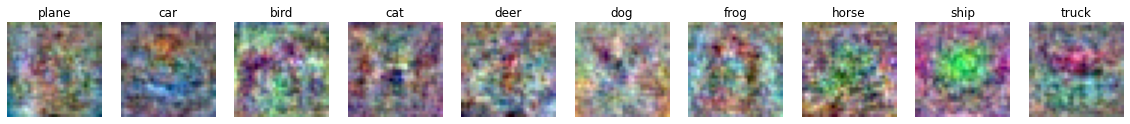

In [19]:
# interpret the weights of the linear model

plt.figure(figsize=(20,5))
for i,c in enumerate(classes):
    bias = model.linear.bias[i].detach().numpy() # get the bias for the class
    template = model.linear.weight[i].detach().numpy().reshape((3,32,32)) # get the weights for the class
    template = template / 2 + 0.5     # unnormalize
    
    # flip the dimensions to get the correct image
    template = np.transpose(template, (1,2,0))
    template -= np.min(template)
    template /= np.max(template)

    plt.subplot(1,len(classes),i+1)
    plt.imshow(template)
    plt.title(c)
    plt.axis('off')

### Exercise 02 📝: Use an MLP to classify the CIFAR-10 dataset

Modify the model to classify the CIFAR-10 dataset with an MLP. <br>
In that notebook there is a `CIFAR10` class that defines a PyTorch Module already: 
```python
class CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(...)
        ...
```

Modify or copy the `CIFAR10` class and change it to an MLP. The number of neurons and layers is up to you! <br>
Do you expect better or worse performance than with the linear classifier? <br>
Report the accuracy of your new network and compare it to the linear model. <br>

Note: Training a larger MLP with loads of data will take a while. So choose your hyperparameters wisely! :)

Furthermore, it's worth noting that this MLP is not expected to perform well with CIFAR10 dataset as it's a more complex dataset compared to MNIST and MLP model does not have enough capacity to learn a good representation of this data, for this purpose convolutional neural network (CNN) is a better approach.